In [1]:
import pint
si = pint.UnitRegistry()

In [2]:
from scipy.stats import lognorm
import numpy as np

In [3]:
from PyCloudParcel.parcel import parcel
from PyCloudParcel.phys import phys

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
si.setup_matplotlib()

In [5]:
rd = np.exp(np.linspace(
    np.log(10.85), 
    np.log(503),
    100
))[::-1] * si.nanometre

# from table 1 
assert round(rd[  1-1].magnitude, 0) == 503
assert round(rd[ 10-1].magnitude, 0) == 355
assert round(rd[ 50-1].magnitude, 1) == 75.3
assert round(rd[100-1].magnitude, 1) == 10.8

rd = rd[::-1]

In [6]:
T0 = 284.3 * si.kelvin
q0 = 7.6 * si.grams / si.kilogram
p0 = 938.5 * si.hectopascals
# density of ai
rho = p0 / phys(si).R(q0) / T0

In [7]:
rm = 50 * si.nanometre
sg = 1.4

nd = lognorm.pdf(rd.magnitude, np.log(sg), 0, rm.magnitude)
nd *= 1000 / np.sum(nd) / si.milligram 

dr = rd[1:] - rd[0:-1]

dn_dr = (nd[0:-1] * rho / dr).to(1/si.centimetre**3 / si.nanometre)

# from fig. 1b
assert dn_dr.magnitude[0] > 1e-2 and dn_dr.magnitude[0] < 1e-1
assert max(dn_dr.magnitude) > 1e1 and max(dn_dr.magnitude) < 1e2
assert dn_dr.magnitude[-1] < 1e-9

<IPython.core.display.Javascript object>


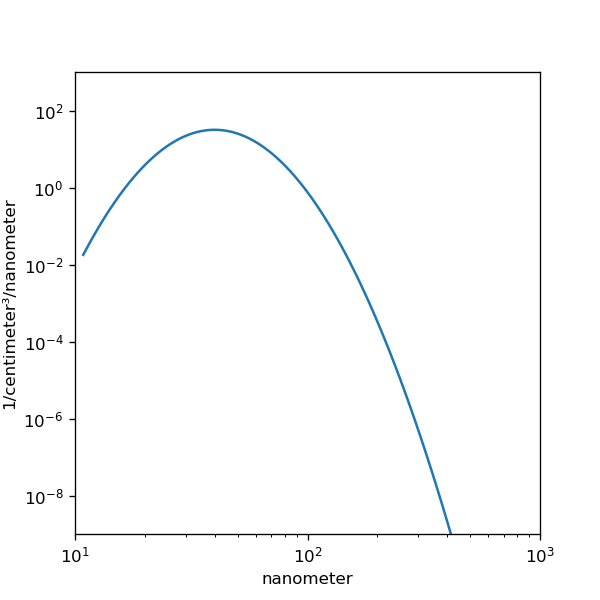

In [8]:
plt.figure(figsize=(5,5))
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e1, 1e3)
plt.ylim(1e-9, 1e3)
plt.yticks(10.**np.arange(-8, 3, step=2))
plt.plot(rd[0:-1], dn_dr)

In [9]:
t0 = 1200 * si.second
f0 = 1 / 1000 * si.hertz

w = lambda t: .5 * (np.where(t < t0, 1, np.sign(-np.sin(2*np.pi * f0 * (t-t0))))) * si.metre / si.second
integ, sys = parcel(
    si = si,
    t = 3 * 3600 * si.seconds,
    T0 = T0,
    q0 = q0,
    p0 = p0,
    w = w,
    nd = nd, 
    rd = rd, 
    kp = 0.53, # Petters and S. M. Kreidenweis mean growth-factor derived
    dt_max = .5 * si.second,
    thermo = ('S','p')
)

In [10]:
ix = sys.ix
fn = sys.fn
ph = sys.ph

In [11]:
assert round(1 + integ.y[ix.S][0], 3) == 0.856

In [12]:
p = integ.y[ix.p] * ix.p_unit
r = fn.r(integ.y[ix.x] * ix.x_unit)
t = integ.t * ix.t_unit
S = integ.y[ix.S] * ix.S_unit

q = ph.q(sys.q1, nd, r)
T = ph.T(S,p,q)

In [13]:
h0 = 600 * si.metre
h = lambda t: h0 + np.cumsum(w(t) * np.append(0, np.diff(t.magnitude)) *si.second) 
h = h(t)

<IPython.core.display.Javascript object>


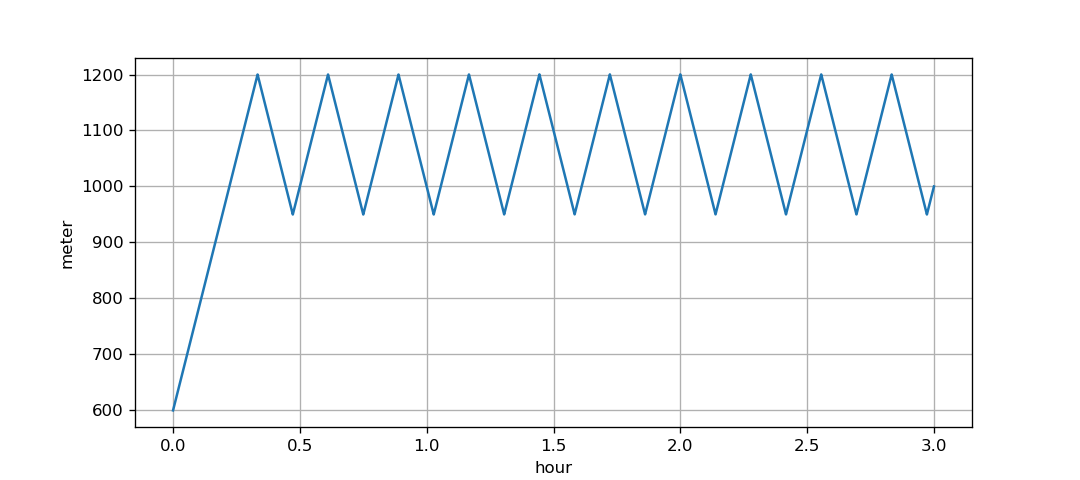

In [14]:
fig, ax = plt.subplots(1, 1,  figsize=(9,4))

ax.plot(t, h, label="T")
ax.grid()
ax.xaxis.set_units(si.hours)

In [15]:
ix51 = 40
ix503 = 99
assert round(rd[  ix51].magnitude, 0) == 51
assert round(rd[ ix503].magnitude, 0) == 503

<IPython.core.display.Javascript object>


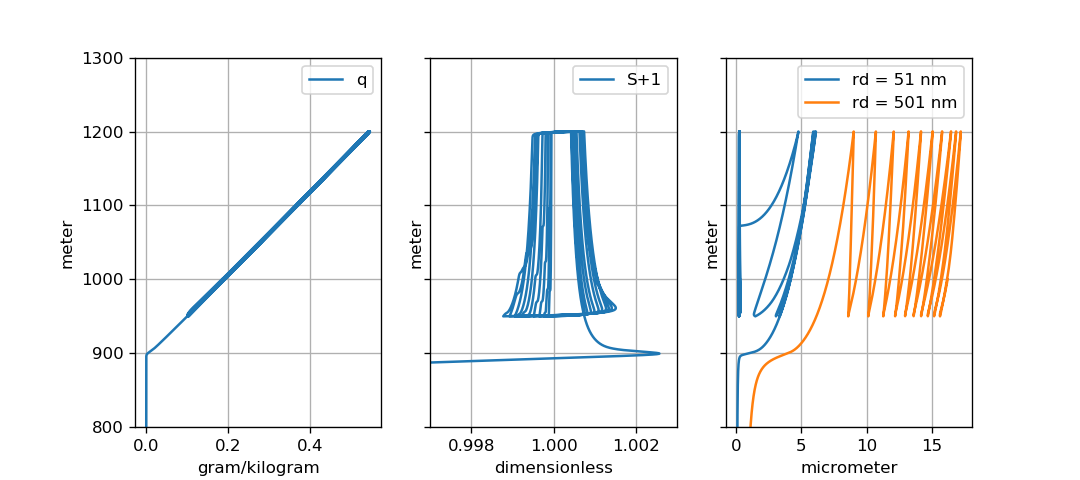

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9,4))

ax1.set_ylim([800, 1300])

ax1.plot(sys.q1 - ph.q(sys.q1, sys.nd, r), h, label="q")
ax1.grid()
ax1.legend()

ax2.plot(S+1, h, label="S+1")
ax2.grid()
ax2.legend()
ax2.set_xlim([0.997, 1.003])

ax3.plot(r[ix51], h, label="rd = 51 nm")
ax3.plot(r[ix503], h, label="rd = 501 nm")
ax3.grid()
ax3.xaxis.set_units(si.micrometre)
ax3.legend()

In [17]:
r_cr = ph.r_cr(sys.kp, sys.rd, T.reshape(-1,1).repeat(len(nd), axis = 1)).transpose()

In [18]:
def rmean(r, n, mask):
    nt = r.shape[1]
    n_dot_r = n.magnitude.dot(np.where(mask, r.magnitude, 0))
    n_tot = np.sum(np.where(mask, n.magnitude.reshape(-1,1).repeat(nt, axis=1), 0), axis=0)
    rmean = np.full(nt, np.nan)
    nmask = n_tot > 0
    rmean[nmask] = n_dot_r[nmask] / n_tot[nmask]
    return rmean * r.units

In [19]:
hist, xedges, yedges = np.histogram2d(
    t.magnitude.reshape(1,-1).repeat(r.shape[0], axis=0).ravel(), 
    r.magnitude.ravel(),
    bins = [256,128], 
    weights = nd.magnitude.reshape(-1,1).repeat(r.shape[1], axis=1).ravel(),
)

<IPython.core.display.Javascript object>


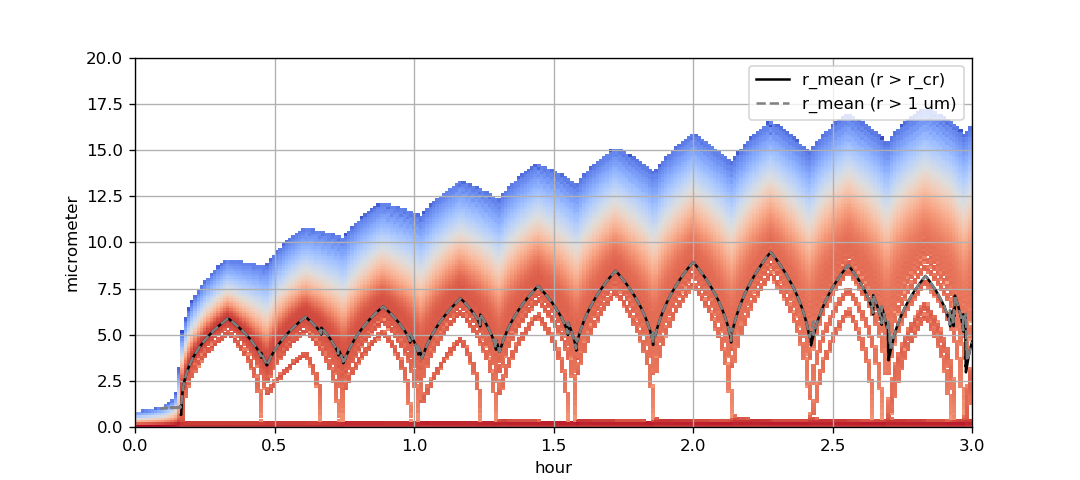

In [20]:
fig, ax = plt.subplots(1, 1,  figsize=(9,4))

xunit = si.hour
yunit = si.micrometres

ax.yaxis.set_units(yunit)
ax.xaxis.set_units(xunit)
ax.set_ylim([0, 20])
c = ax.pcolormesh(
    ph.mgn(xedges * t.units, xunit), 
    ph.mgn(yedges * r.units, yunit), 
    hist.T,
    cmap = 'coolwarm',
    norm = mpl.colors.LogNorm()
)
ax.plot(t, rmean(r, nd, r > r_cr), label="r_mean (r > r_cr)", color='black')
ax.plot(t, rmean(r, nd, r > 1 * si.micrometre), label="r_mean (r > 1 um)", linestyle='--', color='gray')
ax.legend()
ax.grid()